In [4]:
import numpy as np
from scipy import special

def exgaussian_angle_pdf(n=500, mu=44.509, sigma=8.984, tau=30.667, 
                       plot=True, random_state=None):
    """
    Generate samples from a wrapped exGaussian distribution (angles in degrees)
    and plot the histogram + fitted PDF.

    Parameters
    ----------
    n : int
        Number of random samples to generate.
    mu : float
        Mean of the Gaussian part (degrees).
    sigma : float
        Standard deviation of the Gaussian part (degrees).
    tau : float
        Mean of the exponential component (degrees).
    plot : bool
        Whether to show a circular histogram with the PDF.
    random_state : int or None
        Optional seed for reproducibility.

    Returns
    -------
    samples_deg : ndarray
        Array of wrapped angles in degrees, shape (n,).
    pdf_func : callable
        Function `pdf(angle_deg)` that returns the wrapped exGaussian PDF.
    """

    rng = np.random.default_rng(random_state)

    # Generate Samples
    normal_part = rng.normal(loc=mu, scale=sigma, size=n)
    exp_part = rng.exponential(scale=tau, size=n)
    samples_linear = normal_part + exp_part
    samples_deg = np.mod(samples_linear, 180.0)  # wrap to [0, 180)

    # Define the linear exGaussian PDF: A regular Gaussian but with a long tail on the right side
    def exgauss_pdf_linear(x, mu, sigma, tau):
        z = (x - mu) / sigma
        lam = 1.0 / tau
        arg = (sigma * lam - z) / np.sqrt(2.0)
        prefactor = lam / 2.0 * np.exp((lam / 2.0) * (lam * sigma**2 - 2 * (x - mu)))
        return prefactor * special.erfc(arg)

    # Sum over integer multiples of 180 degrees
    def pdf(angle_deg, K=8):
        angle_deg = np.atleast_1d(angle_deg)
        total = np.zeros_like(angle_deg, dtype=float)
        for k in range(-K, K + 1):
            total += exgauss_pdf_linear(angle_deg + 180.0 * k, mu, sigma, tau)
        return total

    # Plot PDF
    if plot:
        import matplotlib.pyplot as plt

        bins = np.linspace(0, 180, 37)
        counts, _ = np.histogram(samples_deg, bins=bins, density=False)
        bin_centers = (bins[:-1] + bins[1:]) / 2.0
        bin_width_deg = bins[1] - bins[0]
        hist_density = counts / (n * bin_width_deg)

        theta_deg = np.linspace(0, 180, 720)
        pdf_vals = pdf(theta_deg)
        pdf_scaled = pdf_vals * (180.0 / np.pi)  # convert to per radian for polar plotting

        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, polar=True)
        ax.bar(np.deg2rad(bin_centers),
               hist_density * (np.pi / 180.0),
               width=np.deg2rad(bin_width_deg),
               alpha=0.6)
        ax.plot(np.deg2rad(theta_deg),
                pdf_scaled * (np.pi / 180.0),
                linewidth=2)
        ax.set_theta_zero_location('N')
        ax.set_theta_direction(-1)
        ax.set_xticks(np.deg2rad(np.arange(0, 360, 45)))
        ax.set_xticklabels([f"{int(t)}°" for t in np.arange(0, 360, 45)])
        ax.set_title(f"Wrapped exGaussian distribution (μ={mu:.1f}°, σ={sigma:.1f}°, τ={tau:.1f}°)")
        plt.show()

        # Initialize position array
        r_array = np.zeros((len(bins) + 1, 2))
        print(r_array.shape)

        # Iterate through bins and accumulate positions
        for i, b in enumerate(bins):
            theta_i = np.radians(b + 2.5)  # convert to radians!
    
            # 2. Compute PDF mass at that angle and convert to arc length
            mass = pdf(np.degrees(theta_i)) * bin_width_deg
            arc = 1 * mass  # can scale total curve length later

            # 3. Compute slope and tangent direction
            slope = - np.cos(np.pi - theta_i) # from coulombic shear criterion
            tangent_angle = np.arctan2(slope,-1)

            # 4. Increment position
            delta_r = np.array([arc * np.cos(tangent_angle), arc * np.sin(tangent_angle)]).T
            print(delta_r.shape)

            r_array[i+1, :] = r_array[i,:] + delta_r  # cumulative update

            ## DEBUG
            if i < 10:
                print(f"i={i}, bin_center_deg={b + bin_width_deg/2:.3f}")
                print("  theta_deg_for_pdf =", np.degrees(theta_i) if theta_i is not None else '??')
                print("  theta_rad =", theta_i)
                print("  mass =", mass)
                print("  arc =", arc)
                print("  slope =", slope)
                print("  tangent_angle (rad) =", tangent_angle)
                print("  delta_r =", delta_r)
                print("  new_r =", r_array[i] + delta_r)
                print("---")
        print(r_array.shape)
        
        plt.figure(figsize=(6, 6))
        plt.plot(r_array[:,0], r_array[:,1], '-o', color='tab:red', lw=1.5, markersize=3)
        plt.title("Reconstructed curve from PDF of angles")
        plt.xlabel("σ₁ (or x)")
        plt.ylabel("σ₂ (or y)")
        plt.axis('equal')
        plt.grid(True)
        plt.show()


    return samples_deg, pdf


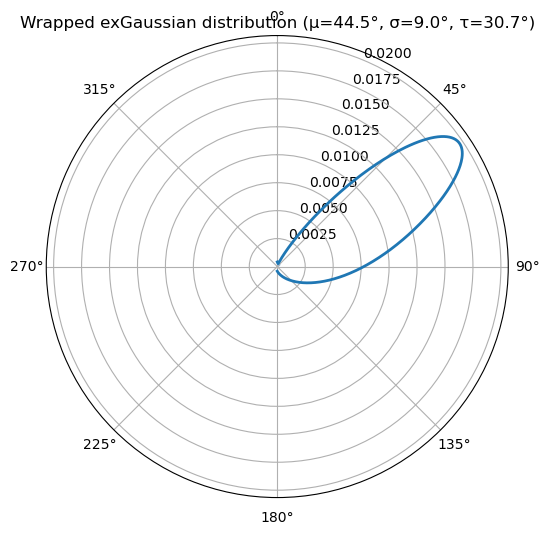

(38, 2)
(1, 2)
i=0, bin_center_deg=2.500
  theta_deg_for_pdf = 2.5
  theta_rad = 0.04363323129985824
  mass = [0.00189687]
  arc = [0.00189687]
  slope = 0.9990482215818578
  tangent_angle (rad) = 2.356670605943805
  delta_r = [[-0.00134193  0.00134065]]
  new_r = [[-0.00134193  0.00134065]]
---
(1, 2)
i=1, bin_center_deg=7.500
  theta_deg_for_pdf = 7.499999999999999
  theta_rad = 0.1308996938995747
  mass = [0.00161422]
  arc = [0.00161422]
  slope = 0.9914448613738104
  tangent_angle (rad) = 2.3604904092830137
  delta_r = [[-0.00114632  0.00113651]]
  new_r = [[-0.00248825  0.00247716]]
---
(1, 2)
i=2, bin_center_deg=12.500
  theta_deg_for_pdf = 12.5
  theta_rad = 0.2181661564992912
  mass = [0.00139677]
  arc = [0.00139677]
  slope = 0.9762960071199333
  tangent_angle (rad) = 2.3681880661597057
  delta_r = [[-0.00099944  0.00097575]]
  new_r = [[-0.00348768  0.00345291]]
---
(1, 2)
i=3, bin_center_deg=17.500
  theta_deg_for_pdf = 17.5
  theta_rad = 0.30543261909900765
  mass = [0.00

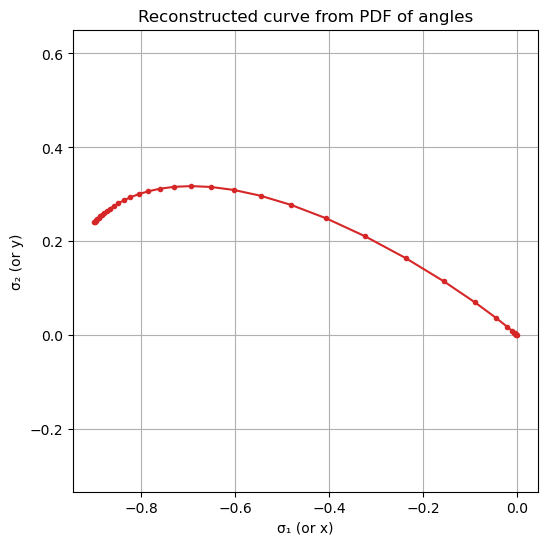

PDF at 30°, 45°, 60°: [0.0016953  0.01368893 0.01903311]


In [5]:
samples, pdf = exgaussian_angle_pdf(n=1000, plot=True)

# Evaluate probability at specific angles
angles = np.array([30, 45, 60])
print("PDF at 30°, 45°, 60°:", pdf(angles))